# Numerical optimization of the detector placement

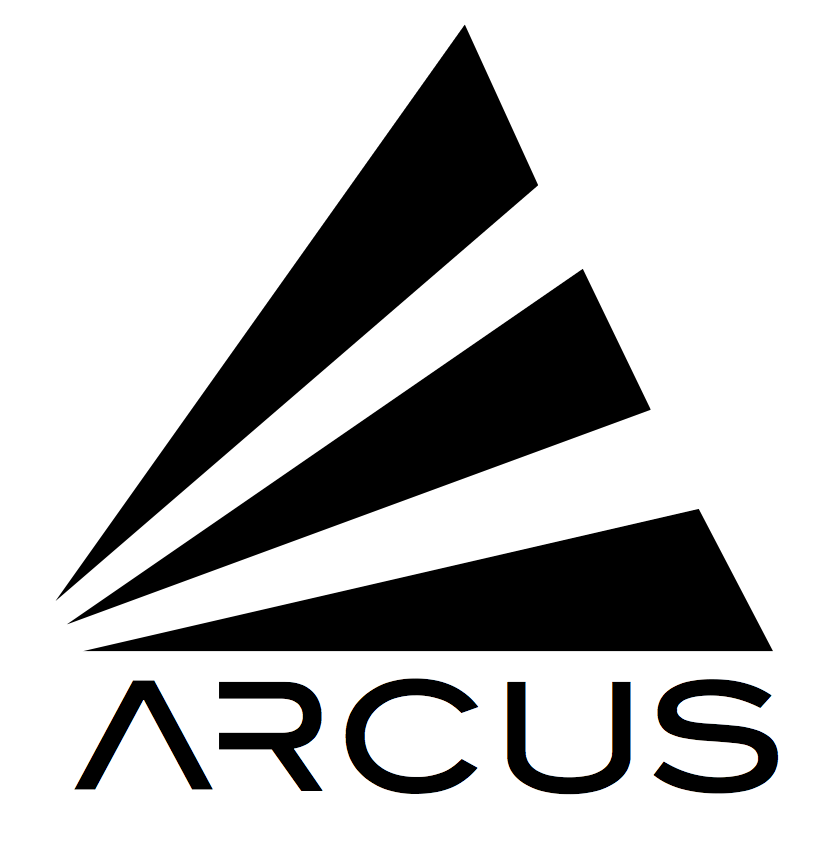

### Revision status: *preparation fo Jan 2018 freeze*
Last revision in version control:

- Author: Hans Moritz Guenther <hgunther@mit.edu>
- commit 20b2211cef2c92866679004307fcf40a868c4cf3
- Date:   Wed Jan 3 15:59:19 2018 -0500

**The version shown here is modified compared to the last commited revision.**

            

This document is git version controlled. The repository is available at https://github.com/hamogu/arcus.
See git commit log for full revision history.

Code was last run with:

- MARXS ray-trace code version 1.2.dev643 (commit hash: c7a3e480d6 from 2018-06-26)
- ARCUS python code version 0.0.dev153 (commit hash: 3d289c95aa from 2018-02-07)
- ARCUS CALDB version hash: 5590a73 (commited on 2018-05-15 )


In [1]:
from nbtemplate import display_header, display_codetoggle, get_path
display_header('OptimizeDetectorPos.ipynb', status='preparation fo Jan 2018 freeze')

In [2]:
import copy
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from arcus import Arcus
import arcus.arcus
from arcus.defaults import DefaultPointing, DefaultSource

%matplotlib inline

## Goal

The CCDs in Arcus are placed on the surface of the Rowland circle. Given the limited number of CCDs available the position along this circle needs to be selected carefully in order to capture the maximal signal. 

## Approach

Arcus is designed to follow a Rowland geometry. The [Rowland Geometry memo](http://space.mit.edu/home/guenther/ARCUS/RowlandGeometry.html) describes this geometry in detail and gives the exact parameters of the Rowland torus. In short, the Arcus spectrograph works by placing gratings on the surface of a torus and setting the CCDs on the opposite side of the torus. After passing through the CAT gratings the rays converge in both dispersion and cross-dispersion direction. When they pass the torus again, the distribution is the narrowest in the dispersion direction, thus placing the CCDs on the torus gives a spectrograph with the best possible resolving power. 

Different spectral orders are diffracted by different angles and thus land at different positions of the torus. The properties of the CAT gratings determine which orders have the highest signal and thus the CCDs need to be placed to catch those orders. Photons that are diffracted into higher or lower orders might miss the detectors and get lost. In an ideal world, every photon could be detected by placing a large number of CCDs, but in practice, coverage is limited because only 16 CCDs can placed on Arcus given the constraints in cost, energy, data volume, and size of the spacecraft.

In this memo, I run a single ray-trace of the Arcus SPOs and CAT gratings. Then, I place CCDs at different positions along the Rowland circle and calculate the number of detected photons to determine the ideal detector placement. 

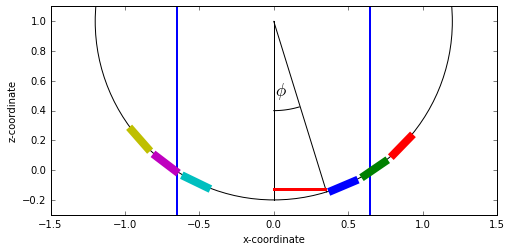

In [3]:
from matplotlib.patches import Circle
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, aspect='equal')
ax.add_patch(Circle([0, 1], radius=1.2, fc="none", ec='k'))
ax.plot([-.65, -.65], [2.5, -.3], 'b', lw=2, label='opt axis')
ax.plot([.65, .65], [2.5, -.3], 'b', lw=2, label='__no_legend__')
ax.plot([0, 0], [1, -.2], 'k')
ax.plot([0, 1.2 * np.sin(0.3)], [1, 1- 1.2 * np.cos(0.3)], 'k')

d = 0.08
for ang in [0.4, 0.6, 0.8, -0.45, -0.65, -0.85]:
    mid = np.array([1.2 * np.sin(ang), 1- 1.2 * np.cos(ang)])
    e1 = mid - d * np.array([np.cos(ang), np.sin(ang)])
    e2 = mid + d * np.array([np.cos(ang), np.sin(ang)])
    plt.plot([e1[0], e2[0]], [e1[1], e2[1]], lw=8)
    
ang = np.arange(0, .3, 0.01)
x = 0.6 * np.sin(ang)
y = 1. - 0.6 * np.cos(ang)
ax.plot(x, y)
ax.text(0.01, 0.5, '$\phi$', fontsize='xx-large')

ax.plot([0, np.sin(0.35)], [1. - 1.2 * np.cos(0.35), 1. - 1.2 * np.cos(0.35)], 'r', lw=3)
    
ax.set_ylim([-0.3, 1.1])
ax.set_xlabel('x-coordinate')
out = ax.set_ylabel('z-coordinate')

The figure above shows a sketch of CCDs on the Rowland circle. Units for the x and z axis in this sketch are arbitrary and not related to the physical dimension of Arcus. The black circle is the Rowland circle. X-rays come from above. The two blue lines mark the position of two optical axes. Colored boxes signify the CCD positions (three on each side in this sketch). The position of the CCDs can be parameterized in different ways, e.g. one could list the x and z coordinate of the CCD edges, or the coordinate of the center (the tilt of the CCD can then be calculated from the condition that it is tangential to the Rowland circle). In the following, we will use either $\phi$, the angle between the centerline of the Arcus telescope (at x=0 in the global instrument coordinate system) and the inner edge of the innermost CCD, or the x coordinate of the innermost edge of the active CCD area (red line) as parameters. The edge of a CCD is a well defined location that can easily be measured during the construction and aligning of the telescope and is thus a more useful reference point than the center of a CCD.

## Constraints on CCD placement

Arcus has four channels, two of which disperse the spectrum along the positive instrument x axis and the other two disperse in the opposite direction, [see Fig 1 in the Rowland Geometry memo](http://space.mit.edu/home/guenther/ARCUS/RowlandGeometry.html). 

We optimize the CCD position taking a number of constraints into account.

- The 16 CCDs are split into two groups of 8 CCDs each. Each group of CCDs **has to capture two zeroths orders** and two dispersed spectra. The zeroth orders are located at a fixed position (-300 mm and + 300 mm), the dispersed spectra cover a larger area.
- There are about 0.8 mm of space between the last active column of a CCD and the physical edge of a chip. The closest possible distance between active CCD areas is thus 1.6 mm, but in order to mount them in the housing correctly, we need a small additional gap, leaving us with a minimum chip gap of 2.15 mm.
- The CCDs need to be shielded from optical light by an optical blocking filter. These filters are only available up to a certain size. Each filter can cover at most 3 CCDs. The filters are surrounded by a small mounting frame, giving a minimum gap between X-ray transparent areas of 4 mm. It is clearly most efficient to place this filter support structure over a CCD chip gap (taking into account that the X-ray beam arrives at an angle). By placing the CCDs not just 2, but 4 mm apart we can avoid wasting active CCD area in the region that will always be shadowed by the filter support.
- Most photons arrive close to the "blaze peak" and the signal becomes weaker further away from the peak. The center of the 8 CCD array will be set on that peak. Given that at most 3 CCDs can be covered by a single filter, the options are 2-3-3, 3-3-2, and 3-2-3. In principle, 3-2-3 is the worst of these options because both gaps are close to the center. We use a 2-3-3 scheme here, but note that in practice the blaze peak is so wide that this choice is not important.
- The two zeroths orders should fall close to the center of a CCD. If they were close to the edge, we would risk to miss the zeroth orders for sources that are acquired slightly off-axis. The zeroths orders are needed to calculate the wavelength scale and having them fall in a chip gap by accident might render the observation useless.
- Chip gaps will inevitably lead to gaps in wavelength coverage. To ensure that no wavelength is completely lost, the two set of 8 CCDs will not be exactly symmetric to the instrument mid-plane, but offset with respect to each other by a few mm to ensure that any wavelength that is invisible on one side will be observed on the other.

## Ray-trace simulation

This simulation uses a flat (in wavelength space) spectrum with photon wavelengths between $12 \;\unicode{xC5}$ and $50 \;\unicode{xC5}$. Effective areas are calcualted from the fraction of photons in some wavelenght bin that are detected (e.g. if half source the photon in one energy bin are detected, that means that the effective area in this bin is half the geometric opening area). This fraction is independent of the input spectrum but contains Poisson noise from the finite number of photons in the simulation. Choosing a flat spectrum leads to similiar noise levels in all wavebands that are analyzed in this memo.

For simplicity, the simulation is done for a single channel. The position of the dispersed spectrum for all other channels can easily inferred from the symmetry of the Arcus design.

In [4]:
wave = np.arange(12., 50., .1) * u.Angstrom
energy = wave.to(u.keV, equivalencies = u.spectral())
flux = np.ones_like(wave)[1:] / np.abs(np.diff(energy))

In [5]:
# Plot of the spectrum
# plt.plot(energy[1:], flux)
# plt.title('Input spectrum')
# plt.ylabel('Flux density [cts/s/area/keV]')
# out = plt.xlabel('energy [keV]')

In [6]:
src = DefaultSource(energy={"energy": energy[::-1][1:], "flux": flux[::-1]})
pnt = DefaultPointing()

photons = src.generate_photons(1000000)
photons = pnt(photons)
photons['wave'] = photons['energy'].to(u.Angstrom, equivalencies=u.spectral())

In [7]:
class ArcusNoDet(Arcus):
    '''Modify the definition of Arcus to remove all detectors'''
    def add_detectors(self, conf):
        return []
  
instrum = ArcusNoDet(channels=['1'])
photons = instrum(photons)

INFO:root:Loading data from gratings/debyewaller
INFO:root:Loading data from gratings/debyewaller
INFO:root:Loading data from gratings/facets
INFO:root:Loading data from filters/sifilter
INFO:root:Loading data from filters/opticalblocking
INFO:root:Loading data from filters/uvblocking
INFO:root:Loading data from detectors/contam
INFO:root:Loading data from detectors/qe
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/marxs-1.2.dev643-py2.7.egg/marxs/math/polarization.py:126: RuntimeWarning: invalid value encountered in divide
  s = s / np.linalg.norm(s, axis=1)[:, None]
INFO:root:Loading data from gratings/L2support


In [8]:
conf = copy.deepcopy(arcus.arcus.defaultconf)

In [9]:
def run_det_phi(photons, phi):
    '''Simulate detector starting as position phi
    
    Set-up a detector starting at phi and run photons through it.
    Return the detected photons (an empty photons list if none is detected).
    '''
    conf['phi_det_start'] = phi
    det = arcus.arcus.DetCamera(conf)
    p = det(photons.copy())
    if 'CCD' in p.colnames:
        p = p[(p['CCD'] >=0) & (p['probability'] > 0)]
    else:
        p = p[[]]  # No photon on any CCD
    return p, det

def Aeff(photons, n):
    '''
    
    Parameters
    ----------
    photons : `astropy.table.Table`
        Photons list
    n : int
        Number of photons originally simulated in the same band as photons.
        If photons was the input specturm, ``n=len(photons)``, however, the way
        this functoin is used, `photons` is often onlt the detected photons, so
        the original number has to be passed in as a separate argument.
    '''
    return photons['probability'].sum() / n * instrum.elements[0].area
    
def Aeff0disp(photons, n):
    pdisp = photons[photons['order'] < 0]
    p0 = photons[photons['order'] == 0]
    return Aeff(p0, n), Aeff(pdisp, n)

def between(photons, interval):
    '''Return index arry to select photons in a specific wavelength range'''
    return (photons['wave'] > interval[0]) & (photons['wave'] < interval[1])

In [10]:
ocolor = ['k', 'c', 'm', 'r', 'g', 'b', 'orange', '0.5', 'olive', 'magenta', 'salmon', 'y', 
          'maroon']
'''Set a color for every order to ensure consistency for the following plots.'''

def plot_detailed(ax, photons, photons_input, area=1):
    pdisp = photons[photons['order'] != 0]
    hist, bins = np.histogram(pdisp['wave'], weights=pdisp['probability'], bins=300)
    # Get hist of input spectrum
    histall, binsall = np.histogram(photons_input['wave'], bins=bins)
    ax.plot(0.5 * (bins[:-1] + bins[1:]), hist / histall * area,
            'k', lw=2, label='dispersed spec')
    
    olist = np.abs(np.array(list(set(photons['order']))))
    olist.sort()
    olist = olist[olist != 0]
    
    for o in olist:
        ind = np.abs(photons['order']) == o
        hist, bins_out = np.histogram(photons['wave'][ind], 
                                      weights=photons['probability'][ind], bins=bins)
        plt.plot(0.5 * (bins[:-1] + bins[1:]), hist / histall * area,
                 color=ocolor[int(abs(o))], label='order {:2g}'.format(abs(o)))

    ax.set_xlabel('wavelength [$\AA$]')
    ax.set_ylabel('$A_\mathrm{eff}$ for channel 1 [cm$^2$]')

In [11]:
area = instrum.elements[0].area.to(u.cm**2)

Reading config file with path definitions: ['../site.cfg']


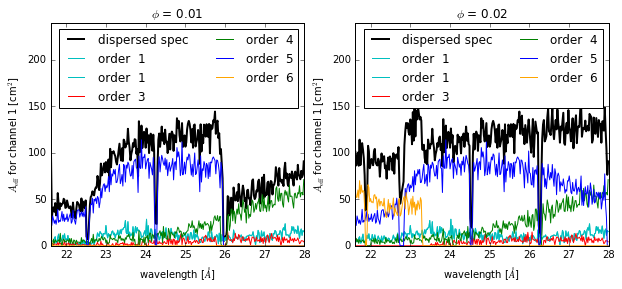

In [26]:
pg11b = photons[between(photons, [21.6, 28.])]

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
p, det = run_det_phi(pg11b, 0.01)
plot_detailed(ax1, p, pg11b, area)
ax1.legend(ncol=2)
ax1.set_title('$\phi$ = {}'.format(0.01))
ax1.set_ylim(1.5 * np.array(ax1.get_ylim()))

ax2 = fig.add_subplot(122)
p2, det = run_det_phi(pg11b, 0.02)
plot_detailed(ax2, p2, pg11b, area)
ax2.legend(ncol=2)
out = ax2.set_title('$\phi$ = {}'.format(0.02))
out = ax2.set_ylim(1.5 * np.array(ax2.get_ylim()))
for ax in [ax1, ax2]:
 ax.set_xlim(21.6, 28.)

import os
fig.savefig(os.path.join(get_path('figures'), 'detposo7.pdf'), bbox_inches='tight') 

The plot above shows the simulated effective area curve zoomed in on the STM requirement G 1-1 (b), which specifies the average effective area for photons between $21.6 \;\unicode{xC5}$ and $28 \;\unicode{xC5}$. The black line shows the sum over all dispersed orders (including very low orders like order 1, where the spectral resolving power might be below the limit of G 1-1 (a) in the STM); the colors are for individual orders. The left and the right plot use the same input photons, but slightly different detector positions. In each plot, the position of the chip gaps can be clearly seen. For most of the wavelength range, the effective area is dominated by one spectral order, but a few more are seen with a significant number of counts. If an order falls into a chip gap for a specific wavelength, the number of counts in this wavelength drops to zero. However, photons are detected in the other orders so that the total effective area dips, but is still different from zero. Because the detectors are in slightly different positions in the left and right plot, different wavelengths fall into the chip gaps. In the right plot, the CCDs are positioned at larger distance from the zeroth order and thus the order 6 is seen out to $>23 \;\unicode{xC5}$, while on the left plot, essentially no 6 order photon is seen. On the other hand, order 3 is off the chip for the right plot for $<23.5 \;\unicode{xC5}$, while it is always seen in the left plot. The CAT gratings disperse more light into order 6 than order 3, so gaining order 6 at the cost of loosing order 3 increases the average effective area.

In [13]:
phi_det_start = np.arange(0.0, 0.055, 0.0005)
aeff = np.zeros((len(phi_det_start), 5)) * u.cm**2
aeff0 = np.zeros_like(phi_det_start) * u.cm**2
dets = []
wvlintervals = [[21.6, 28], [33.7, 40.], [16., 21.6], [12., 50]]

for i, phi in enumerate(phi_det_start):
    p, det = run_det_phi(photons, phi)
    for j, interval in enumerate(wvlintervals):
        a0, adisp = Aeff0disp(p[between(p, interval)], between(photons, interval).sum())
        aeff[i, 4] = a0
        aeff[i, j] = adisp
    dets.append(det)

In [14]:
# Also check that "- v_y" is the correct direction if CCDS are turned
x_innerccd = np.array([(d.elements[8].geometry('center') - d.elements[8].geometry('v_y'))[0] for d in dets])

We now calculate the average effective area over four wavelength bands that are discussed in the science tracability matrix (STM), namely instrument requirement G1-1 (b): $21.6-28\;\unicode{xC5}$, G1-1(c): $33.7-40\;\unicode{xC5}$, G1-2 (a): $16.0-21.6\;\unicode{xC5}$, and G3-1 (b): $12-50\;\unicode{xC5}$. The figure below shows the averaged effective area depending on the position of the first CCD.

Reading config file with path definitions: ['../site.cfg']


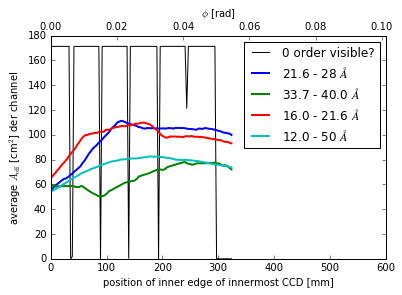

In [25]:
from scipy.interpolate import UnivariateSpline

fig = plt.figure()
ax1 = fig.add_subplot(111)     # phi scale
ax2 = ax1.twiny() 

ax1.plot(x_innerccd, aeff[:, 4] * 30, 'k', lw=1, label='0 order visible?')

for i in range(4):
    ax1.plot(x_innerccd, aeff[:, i], lw=2, label='{} - {} $\AA$'.format(wvlintervals[i][0], wvlintervals[i][1]))
    

ax1.legend()
ax1.set_ylabel('average $A_{\mathrm{eff}}$ [cm$^2$] der channel')
ax1.set_xlabel('position of inner edge of innermost CCD [mm]')
ax2.set_xlabel('$\phi$ [rad]')

# Spline fit to allow extrapolation when xlim set outside of known region
deltax2phi = UnivariateSpline(x_innerccd, phi_det_start)


def update_ax2(ax1):
   x1, x2 = ax1.get_xlim()
   ax2.set_xlim(deltax2phi(x1), deltax2phi(x2))
   ax2.figure.canvas.draw()

# automatically update ylim of ax2 when ylim of ax1 changes.
ax1.callbacks.connect("xlim_changed", update_ax2)

out = ax1.set_xlim([0, 600])

fig.savefig(os.path.join(get_path('figures'), 'detposall.pdf'), bbox_inches='tight') 

The black line indicates when the zeroth order is detected on a CCD on the other side or not (remember that the other channel is offset by 5 mm). The chip gaps for the zeroth order are not very large. We use a step size of $\Delta \phi = 0.0005$ rad, which is comparable to the width of the chip gap. Thus, we do not always have a simulation where the zeroth order is lost completely for every gap. For example, around 250 mm, the zeroth order is right on the edge of a CCD, leading to some loss of signal. Even if the black curve does not go to 0, these parameters need to be avoided, because, as explained above, the zeroth orders need to be comfortable away form chip gaps anyway. Note that for the zeroth order we do not show the effective area on the y axis, but just some relative scaling marking the regions where the zeroths order is detectable at all. The requirement that each set of 8 CCDs must image two zeroths orders sets an upper limit for the inner edge of the innermost CCD at 300 mm, the location of the zeroth order.

Looking at the colored curves, we see that the behavior is relatively smooth. Because we average over a range of wavelengths, individual chip gaps are not important here. Somewhere in the range of wavelengths, there will always be a chip gap. Instead, the shape of these curves is driven by the overall shape of the blaze peak. For the blaze angle and focal length of Arcus, the blaze peak is wider than the area captured by just 8 CCDs on each side. That is why the placement shows so little sensitivity between about 150 and 300 mm. For every photon lost on the one side of the CCDs, we pick up another one on the other side. This makes the design of the cameras and the focal plane easier - optical constraints do not require an exact value for the position of the inner edge of the innermost CCD, so this value can be found in trade-off between optics and engineering requirements.

The science requirement are most stringent for G1-1 (b): $21.6-28\;\unicode{xC5}$, and G1-1(c): $33.7-40\;\unicode{xC5}$, which are shown by the blue and green curve, respectively. These two curves favor CCDs further out. The blue curve is mostly flat after about 150 mm, the green curve continues to rise until about 200 mm.

There is one more consideration that is not directly visible in the chart above: Higher orders offer higher resolving power. 

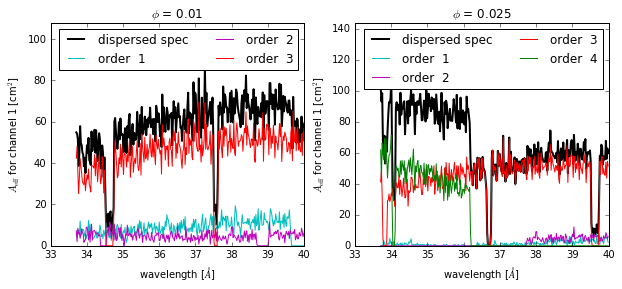

In [16]:
pg11c = photons[between(photons, [33.7, 40.])]

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
p, det = run_det_phi(pg11c, 0.01)
plot_detailed(ax1, p, pg11c, area)
ax1.legend(ncol=2)
out = ax1.set_title('$\phi$ = {}'.format(0.01))
ax1.set_ylim(1.2 * np.array(ax1.get_ylim()))

ax2 = fig.add_subplot(122)
p2, det = run_det_phi(pg11c, 0.025)
plot_detailed(ax2, p2, pg11c, area)
ax2.legend(ncol=2)
out = ax2.set_title('$\phi$ = {}'.format(0.025))
out = ax2.set_ylim(1.2 * np.array(ax2.get_ylim()))

This plot shows the effective area over the wavelength again, for G1-1(c): $33.7-40\;\unicode{xC5}$ for two different possible CCD placements. While the average effective area over the bandpass is very similar (see plot above), in the left scenario this is based almost entirely on order 3, while in the right scenario order 4 is visible for about half the wavelength range in question. This reduces the impact of the chip gap around 34 $\unicode{xC5}$ and it also offers a better spectral resolving power in this region.

## Results

Based on the plot above, I recommend a detector placement where the innermost of the inner CCD is at about 220 mm from the symetry plane. This placement maximizes the effective area for G1-1 (b): $21.6-28\;\unicode{xC5}$, and G1-1(c): $33.7-40\;\unicode{xC5}$.

The figure below shows which orders contribute at each wavelength for one particular channel. There are a few cases where chip gaps lead to severe drops in effective area, e.g. around $40\;\unicode{xC5}$. This happens particularly at longer wavelength where orders are further apart because the diffraction angle is larger and thus only one order contributes to the total observed signal. These cases show how important it is that the second set of CCDs is offset by a few mm to avoid having chip gaps in all spectra at the same position. 

IndexError: list index out of range

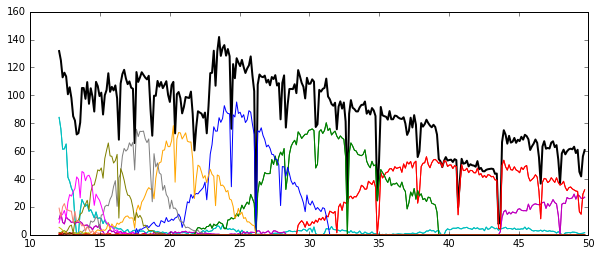

In [17]:
phi_recommended = 0.037
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(111)
p, det = run_det_phi(photons, phi_recommended)
plot_detailed(ax1, p, photons, area)
ax1.legend(ncol=3)
out = ax1.set_title('$\phi$ = {}'.format(phi_recommended))
out = ax1.set_ylim(1.4 * np.array(ax1.get_ylim()))

For reference, the CCD *center* positions in (x,y,z) for this detector placement are listed below:

In [19]:
np.set_printoptions(precision=3, formatter={'float': lambda x: '{:5.1f}'.format(x)})
detcen = np.array([d.geometry('center')[:3] for d in det.elements]) * u.mm
print(detcen)

[[-611.3   0.0  23.9]
 [-560.2   0.0  18.9]
 [-509.2   0.0  14.3]
 [-456.2   0.0  10.0]
 [-405.0   0.0   6.2]
 [-353.8   0.0   3.0]
 [-300.7   0.0   0.0]
 [-249.5   0.0  -2.3]
 [244.5   0.0  -2.5]
 [295.8   0.0  -0.2]
 [348.8   0.0   2.7]
 [400.0   0.0   5.9]
 [451.2   0.0   9.6]
 [504.2   0.0  13.8]
 [555.3   0.0  18.4]
 [606.3   0.0  23.4]] mm


Remember that the zeroth orders are located at -300 and +300 mm. Both locations are more than 1 cm from the chip edge.

Lastly, we simulate a spectrum for all 4 channels of Arcus to show how the 5 mm offset prevents gaps in wavelength coverage.

In [20]:
p4 = src.generate_photons(1000000)
p4 = pnt(p4)
p4['wave'] = p4['energy'].to(u.Angstrom, equivalencies=u.spectral())

instrum4 = ArcusNoDet()
p4 = instrum4(p4)
p4 = det(p4)

INFO:root:Loading data from gratings/debyewaller
INFO:root:Loading data from gratings/debyewaller
INFO:root:Loading data from gratings/facets
INFO:root:Loading data from gratings/facets
INFO:root:Loading data from gratings/facets
INFO:root:Loading data from gratings/facets
INFO:root:Loading data from filters/sifilter
INFO:root:Loading data from filters/opticalblocking
INFO:root:Loading data from filters/uvblocking
INFO:root:Loading data from detectors/contam
INFO:root:Loading data from detectors/qe
INFO:root:Loading data from gratings/L2support


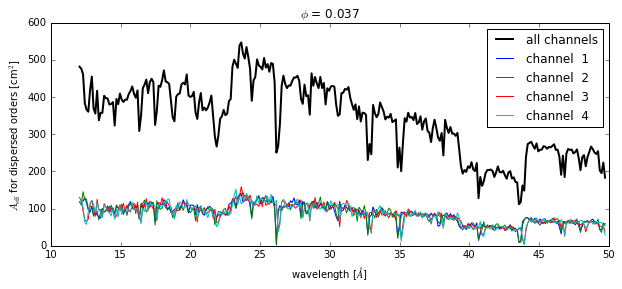

In [21]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(111)
hist_in, bins = np.histogram(p4['wave'], bins=300)
ind = (p4['order'] != 0) & (p4['CCD'] > 0)
hist, bins_out = np.histogram(p4['wave'][ind], 
                              weights=p4['probability'][ind], bins=bins)
ax1.plot(0.5 * (bins[:-1] + bins[1:]), hist / hist_in * instrum4.elements[0].area.to(u.cm**2),
         'k', lw=2, label='all channels')

for i in range(4):
    pchan = p4[p4['aperture'] == i]
    hist_in, bins_out = np.histogram(pchan['wave'], bins=bins)
    ind = (pchan['order'] != 0) & (pchan['CCD'] > 0)
    hist, bins_out = np.histogram(pchan['wave'][ind], 
                                  weights=pchan['probability'][ind], bins=bins)
    # area was dfined above and it area per channel
    ax1.plot(0.5 * (bins[:-1] + bins[1:]), hist / hist_in * area,
                   label='channel {:2g}'.format(i + 1))

    ax.plot()
ax1.legend()
out = ax1.set_title('$\phi$ = {}'.format(phi_recommended))
ax1.set_xlabel('wavelength [$\AA$]')
out = ax1.set_ylabel('$A_\mathrm{eff}$ for dispersed orders [cm$^2$]')

In the current set-up, there are two pairs of channels, where each pair has the zeroth orders at the same x position. Thus, the two channels within a pair have the chip gaps at identical places and effective area curves on top of each other (except for the Poisson noise doe to the finite number of photons used in this simulation). However, the asymmetry between the two sets of 8 CCDs places the chip gaps between the two pairs at slightly different positions as shown in the plot. In the summed effective area this leads to chip gaps that are at most 50% deep and that have a double-humped structure.



## Discussion

### Robustness of results
The simulation results in this memo include most known effects of the Arcus performance, in particular, the pointing jitter. On the other hand, MARXS uses a very simple model for the SPOs. While the absolute scaling of the effective area might carry some uncertainty, relative results (i.e. the relative change in effective area for different detector positions) are expected to be robust.

### Mechanical integration
This memo does not address the problem of the mechnical integration, i.e. can the dimensions of the camera shown here be accomodated inside the space craft.


### A proposal to reduce the effect of chip gaps further
(My alingment tolerance calculations)[http://space.mit.edu/home/guenther/ARCUS/Tolerances.html] show that an offset in the x direction by a few mm has little influence on the resolving power, so one could reduce the impact of the chip gaps by introducing a small (e.g. -2.5 and +2.5 mm with resport to the nominal position) offset between the two channels in each pair and at the same time increase the asymmetry between the two CCDs sets slightly (from 5 mm to 10 mm). This would make each chip gap to be no more than 25% deep and give them a quadruple humped structure.

In [18]:
display_codetoggle()